<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/TStool/gluonts_day5(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/jlgleason/gluonts-forecasting-applications.git

Cloning into 'gluonts-forecasting-applications'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 72 (delta 30), reused 57 (delta 19), pack-reused 0
Unpacking objects: 100% (72/72), done.


In [3]:
%cd gluonts-forecasting-applications/

/content/gluonts-forecasting-applications


In [4]:
!pip install gluonts
!pip install mxnet-cu101

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 18 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


Thanks https://github.com/jlgleason/gluonts-forecasting-applications/blob/master/notebooks/COVID-US-Forecasting.ipynb

# Data Preprocessing
1. filter out non-US countries
2. fill 'NaN' Province/State values with Country/Region values
3. (optionally) apply log transformation to target values

In [11]:
# load and clean data
import pandas as pd

train_all = pd.read_csv("./data/train.csv")

In [12]:
train_all

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0000,65.0000,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0000,65.0000,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0000,65.0000,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0000,65.0000,2020-01-26,0.0,0.0
...,...,...,...,...,...,...,...,...
17887,26378,NaN,Zambia,-15.4167,28.2833,2020-03-20,2.0,0.0
17888,26379,NaN,Zambia,-15.4167,28.2833,2020-03-21,2.0,0.0
17889,26380,NaN,Zambia,-15.4167,28.2833,2020-03-22,3.0,0.0
17890,26381,NaN,Zambia,-15.4167,28.2833,2020-03-23,3.0,0.0


In [13]:
# load and clean data
import pandas as pd


def preprocess(
    frame: pd.DataFrame,
    log_transform: bool = False
):
    
    # set index
    new_frame = frame.set_index('Date')

    # filter countries
    new_frame = new_frame[new_frame['Country/Region'] == 'US']
        
    # convert target values to log scale
    if log_transform:
        new_frame[['ConfirmedCases', 'Fatalities']] = np.log1p(
            new_frame[['ConfirmedCases', 'Fatalities']].values
    )
    
    return new_frame

def split(
    df: pd.DataFrame, 
    date: str = '2020-03-20'
):
    train = df.loc[df.index < date] 
    test = df.loc[df.index >= date]
    return train, test

train_all = preprocess(train_all)
_, train_all = split(train_all, date = '2020-03-01')
train, test = split(train_all)

In [14]:
train_all

,Id,Province/State,Country/Region,Lat,Long,ConfirmedCases,Fatalities
Date,,,,,,,
2020-03-01,19942,Alabama,US,32.3182,-86.9023,0.0,0.0
2020-03-02,19943,Alabama,US,32.3182,-86.9023,0.0,0.0
2020-03-03,19944,Alabama,US,32.3182,-86.9023,0.0,0.0
2020-03-04,19945,Alabama,US,32.3182,-86.9023,0.0,0.0
2020-03-05,19946,Alabama,US,32.3182,-86.9023,0.0,0.0
...,...,...,...,...,...,...,...
2020-03-20,25262,Wyoming,US,42.7560,-107.3025,19.0,0.0
2020-03-21,25263,Wyoming,US,42.7560,-107.3025,23.0,0.0
2020-03-22,25264,Wyoming,US,42.7560,-107.3025,24.0,0.0


## Data Exploration

In [15]:
# plot confirmed cases and fatalities in train
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [16]:
cum_train = train.groupby('Date').sum()
cum_test = test.groupby('Date').sum()

In [17]:
cum_train 

,Id,Lat,Long,ConfirmedCases,Fatalities
Date,,,,,
2020-03-01,1310365,2190.7509,-4890.7857,44.0,0.0
2020-03-02,1310423,2190.7509,-4890.7857,45.0,0.0
2020-03-03,1310481,2190.7509,-4890.7857,45.0,0.0
2020-03-04,1310539,2190.7509,-4890.7857,45.0,0.0
2020-03-05,1310597,2190.7509,-4890.7857,45.0,0.0
2020-03-06,1310655,2190.7509,-4890.7857,45.0,0.0
2020-03-07,1310713,2190.7509,-4890.7857,66.0,0.0
2020-03-08,1310771,2190.7509,-4890.7857,66.0,0.0
2020-03-09,1310829,2190.7509,-4890.7857,66.0,0.0


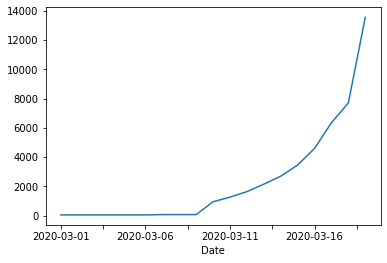

In [20]:
cum_train.ConfirmedCases.plot()

In [25]:
def plot_observations(
    target: str = 'ConfirmedCases'
):
    fig = plt.figure(figsize=(15, 6.1), facecolor="white",  edgecolor='k')

    train_ds = ListDataset(
        [{"start": cum_train.index[0], "target": cum_train[target].values}],
        freq = "D",
    )
    test_ds = ListDataset(
        [{"start": cum_test.index[0], "target": cum_test[target].values}],
        freq = "D",
    )
    
    for tr, te in zip(train_ds, test_ds):
        tr = to_pandas(tr)
        te = to_pandas(te)
        tr.plot(linewidth=2, label = f'train {target}')
        tr[-1:].append(te).plot(linewidth=2, label = f'test {target}')
    
    plt.axvline(cum_train.index[-1], color='purple') # end of train dataset
    plt.title(f'Cumulative number of {target} in the US', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(which="both")
    plt.show()

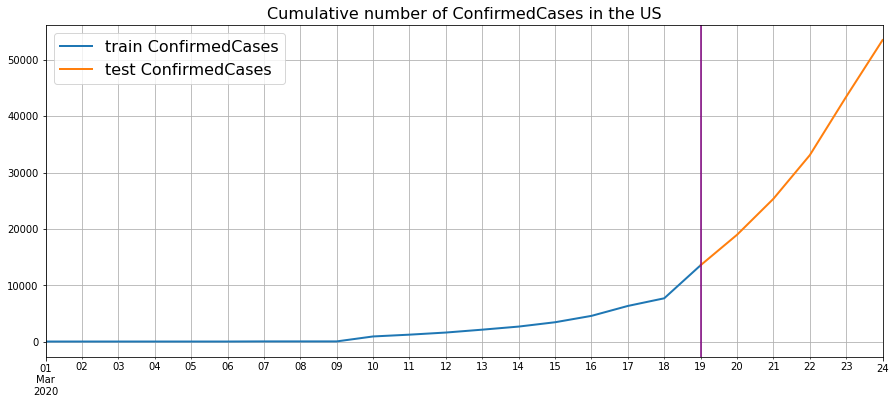

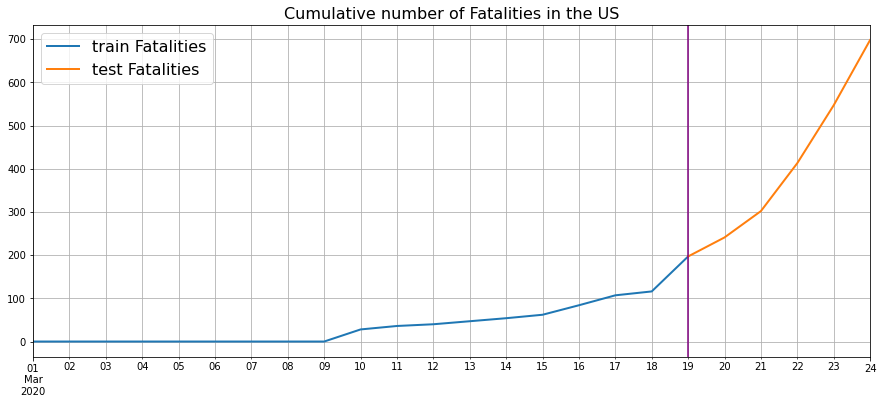

In [26]:
plot_observations('ConfirmedCases')
plot_observations('Fatalities')

## Data Augmentation
Categorical feature for 'Province/State'<br>
Categorical feature for 'Country/Region'<br>

In [28]:
from sklearn.preprocessing import OrdinalEncoder

expend = pd.read_csv(
    './data/state_level_data/healthcare_expenditures_2014.csv', 
    header=2, 
    skipfooter=16,
    engine='python'
)
expend['Total Health Spending'] = expend['Total Health Spending'].str.lstrip('$').astype(int)

expend_per_c = pd.read_csv(
    './data/state_level_data/healthcare_expenditures_per_capita_2014.csv', 
    header=2, 
    skipfooter=34,
    engine='python'
)
expend_per_c = expend_per_c.applymap(lambda x: x.lstrip('$'))
expend_per_c.loc[:, expend_per_c.columns != 'Location'] = expend_per_c.loc[:, expend_per_c.columns != 'Location'].astype(int)

private = pd.read_csv(
    './data/state_level_data/private_health_spending_2014.csv', 
    header=2, 
    skipfooter=13,
    engine='python'
)
private['Total Private Health Insurance Spending'] = private['Total Private Health Insurance Spending'].str.lstrip('$').astype(int)

private_per_c = pd.read_csv(
    './data/state_level_data/private_spending_per_capita_2014.csv', 
    header=2, 
    skipfooter=16,
    engine='python'
)
private_per_c['Per Capita Private Health Insurance Spending'] = private_per_c['Per Capita Private Health Insurance Spending'].str.lstrip('$').astype(int)

hospital = pd.read_csv(
    './data/state_level_data/hospital_expenses_2018.csv', 
    header = 2, 
    skipfooter=14,
    engine='python'
)
hospital.loc[hospital['State/Local Government Hospitals'].isna(), 'State/Local Government Hospitals'] = \
    hospital.loc[~hospital['State/Local Government Hospitals'].isna(), 'State/Local Government Hospitals'].mode()[0]    
hospital.loc[hospital['For-Profit Hospitals'].isna(), 'For-Profit Hospitals'] = \
    hospital.loc[~hospital['For-Profit Hospitals'].isna(), 'For-Profit Hospitals'].mode()[0]    
hospital = hospital.applymap(lambda x: x.lstrip('$'))
hospital.loc[:, hospital.columns != 'Location'] = hospital.loc[:, hospital.columns != 'Location'].astype(int)

def join(
    df: pd.DataFrame,
    health_df: pd.DataFrame
):
    
    # join, delete merge columns
    new_df = df.reset_index().merge(
        health_df,
        left_on = 'Province/State',
        right_on = 'Location',
        how = 'inner'
    ).set_index('Date')
    new_df = new_df.drop(columns=['Location'])
    
    assert not new_df.isnull().sum().any()
    
    return new_df

def encode(
    df: pd.DataFrame
):
    """ encode 'Province/State' and 'Country/Region' categorical variables as numerical ordinals"""
    
    enc = OrdinalEncoder()
    df['Province/State'] = enc.fit_transform(df['Province/State'].values.reshape(-1,1))
    return df, enc

join_df = join(train_all, expend)
join_df = join(join_df, expend_per_c)
join_df = join(join_df, private)
join_df = join(join_df, private_per_c)
join_df = join(join_df, hospital)

all_df, enc = encode(join_df)
train_df, test_df = split(all_df)
_, val_df = split(all_df, date = '2020-03-15')

In [31]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1224 entries, 2020-03-01 to 2020-03-24
Data columns (total 22 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Id                                                1224 non-null   int64  
 1   Province/State                                    1224 non-null   float64
 2   Country/Region                                    1224 non-null   object 
 3   Lat                                               1224 non-null   float64
 4   Long                                              1224 non-null   float64
 5   ConfirmedCases                                    1224 non-null   float64
 6   Fatalities                                        1224 non-null   float64
 7   Total Health Spending                             1224 non-null   int64  
 8   Hospital Care                                     1224 non-null   object 
 9   Physician

In [30]:
not_real_cols = ['Id', 'Province/State', 'Country/Region', 'Lat', 'Long', 'ConfirmedCases', 'Fatalities']
REAL_VARS = [col for col in all_df.columns if col not in not_real_cols]

In [33]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import typing


def build_dataset(
    frame: pd.DataFrame,
    target: str = 'Fatalities',
    cat_vars: typing.List[str] = ['Province/State'],
    real_vars: typing.List[str] = REAL_VARS
):
    return ListDataset(
        [
            {
                FieldName.START: df.index[0], 
                FieldName.TARGET: df[target].values,
                FieldName.FEAT_STATIC_CAT: df[cat_vars].values[0],
                FieldName.FEAT_STATIC_REAL: df[real_vars].values[0]
            }
            for g, df in frame.groupby(by=['Province/State'])
        ],
        freq = "D",
    )


In [34]:
training_data_fatalities = build_dataset(train_df)
training_data_cases = build_dataset(train_df, target = 'ConfirmedCases')
training_data_fatalities_all = build_dataset(all_df)
training_data_cases_all = build_dataset(all_df, target = 'ConfirmedCases')
val_data_fatalities = build_dataset(val_df)
val_data_cases = build_dataset(val_df, target = 'ConfirmedCases')

## Fit DeepAR Model Estimates
The DeepAR model was proposed by David Salinas, Valentin Flunkert, and Jan Gasthaus in "DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks" (https://arxiv.org/abs/1704.04110). The approach trains an autoregressive RNN to produces time-variant parameters of a specified distribution on a large collection of related time series. The learned distribution can then be used to produce probabilistic forecasts. Here we use the authors' GluonTS implementation (https://gluon-ts.mxnet.io/index.html).

We believe the probabilistic nature of the DeepAR forecasts is a feature that differentiates our approach from others we have seen so far. Specifically, the ability to provide both confidence intervals and point estimates allows one to better understand the range of possible trajectories, from the worst-case scenario, to the best-case scenario, to the expected scenario.

TODO:

Experiment with adding learned Box Cox transformation before learning Negative Binomial paramaters?

In [37]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.mx.distribution import NegativeBinomialOutput
import mxnet as mx
import numpy as np

# set random seeds for reproducibility
mx.random.seed(42)
np.random.seed(42)

def fit(
    training_data: ListDataset,
    validation_data: ListDataset = None,
    use_real_vars: bool = True,
    pred_length: int = 5,
    epochs: int = 20,
    weight_decay: float = 5e-5
):
    estimator = DeepAREstimator(
        freq="D", 
        prediction_length=pred_length,
        use_feat_static_real = use_real_vars,
        use_feat_static_cat = True,
        cardinality = [train['Province/State'].nunique()], #station id
        distr_output=NegativeBinomialOutput(),
        trainer=Trainer(
            epochs=epochs,
            learning_rate=0.001, 
            batch_size=64,
            weight_decay=weight_decay
        ),
    )
    _, trained_net, predictor = estimator.train_model(
        training_data = training_data, 
        validation_data = validation_data
    )
    
    return predictor, trained_net

In [38]:
#predictor_fatalities, net = fit(training_data_fatalities, val_data_fatalities, use_real_vars = False)
#predictor_fatalities_aug, aug_net = fit(training_data_fatalities, val_data_fatalities)
#predictor_cases = fit(training_data_cases, val_data_cases, epochs=20)
predictor_fatalities_all = fit(training_data_fatalities_all, pred_length=7, use_real_vars = False)
#predictor_cases_all = fit(training_data_cases_all, pred_length=7)

100%|██████████| 50/50 [00:01<00:00, 28.03it/s, epoch=20/20, avg_epoch_loss=0.471]


In [40]:
enc.transform(np.array('New York').reshape(1,-1))[0]

array([32.])

# Plot predictions from fit model parameters

In [41]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt
from typing import List

def plot_forecast(
    predictor,
    location: str = 'New York',
    target: str = 'Fatalities',
    cat_vars: str = 'Province/State',
    real_vars: typing.List[str] = REAL_VARS,
    log_preds: bool = False,
    fontsize: int = 16
):
    fig = plt.figure(figsize=(15, 6.1), facecolor="white",  edgecolor='k')

    # plot train observations, true observations from public test set, and forecasts
    location_tr = enc.transform(np.array(location).reshape(1,-1))[0]
    tr_df = train_df[train_df['Province/State'].values == location_tr]
    train_obs = ListDataset(
        [{
            FieldName.START: tr_df.index[0], 
            FieldName.TARGET: tr_df[target].values,
            FieldName.FEAT_STATIC_CAT: tr_df[cat_vars].values[0].reshape(1,),
            FieldName.FEAT_STATIC_REAL: tr_df[real_vars].values[0]
        }],
        freq = "D",
    )
    te_df = test_df[test_df['Province/State'].values == location_tr]
    test_gt = ListDataset(
        [{"start": te_df.index[0], "target": te_df[target].values}],
        freq = "D",
    )
    for train_series, gt, forecast in zip(train_obs, test_gt, predictor.predict(train_obs)):
        
        train_series = to_pandas(train_series)
        #gt = to_pandas(gt)
        
        if log_preds:
            train_series = np.expm1(train_series)
            gt = np.expm1(gt)
            forecast.samples = np.expm1(forecast.samples)
        
        train_series.plot(linewidth=2, label = 'train series')
        #gt.plot(linewidth=2, label = 'test ground truth')
        forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
        
    plt.title(f'Cumulative number of forecasted {target} in {location}', fontsize=fontsize)
    plt.legend(fontsize = fontsize)
    plt.grid(which='both')
    plt.show()

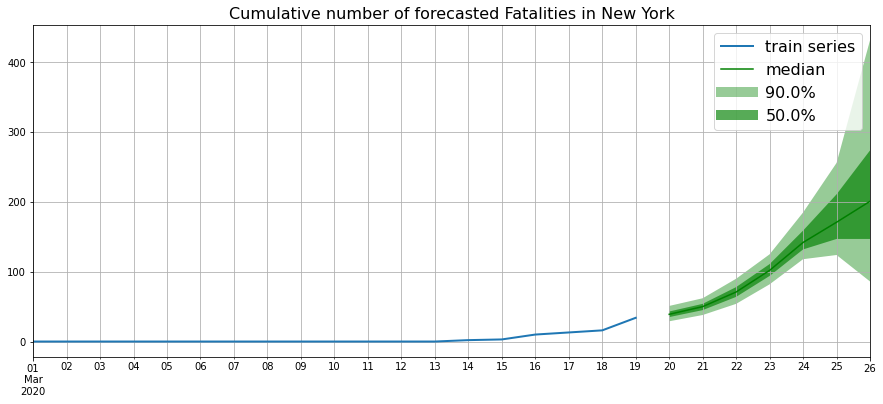

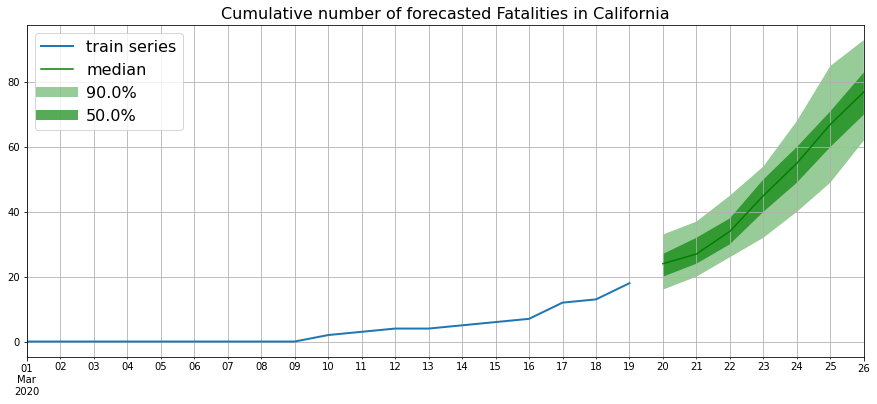

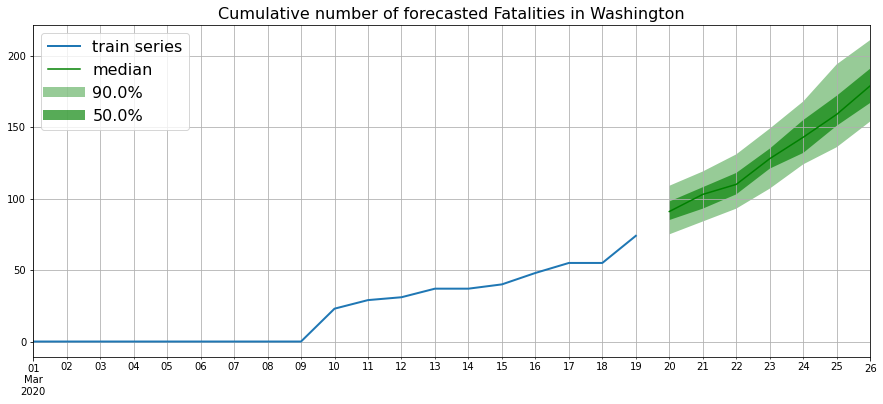

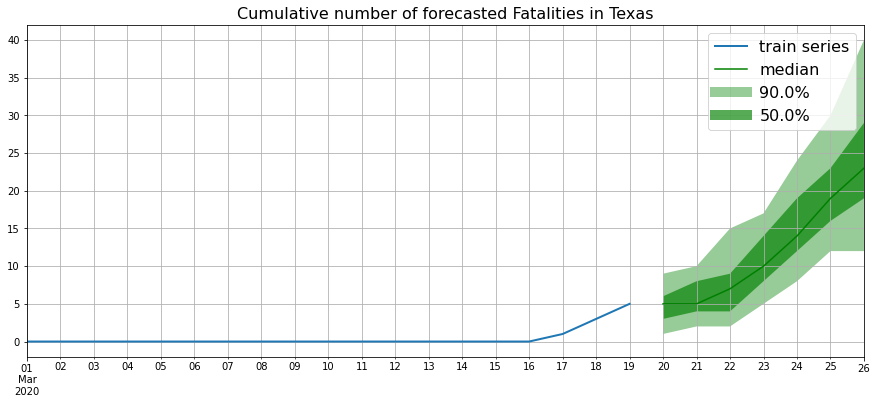

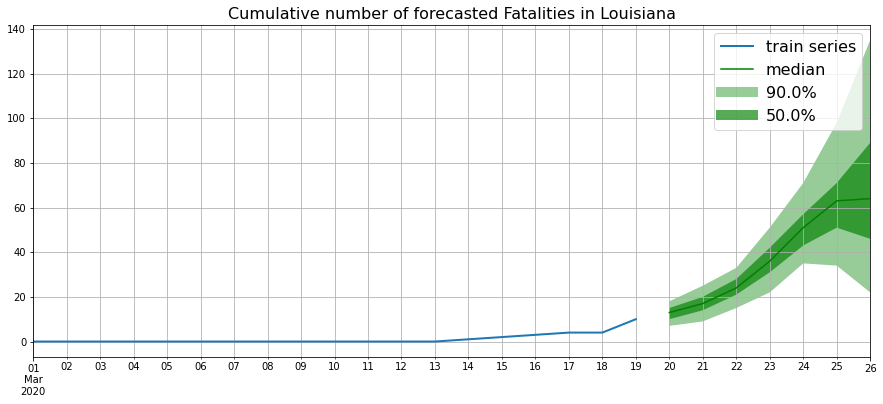

In [42]:
plot_forecast(predictor_fatalities_all[0], 'New York')
plot_forecast(predictor_fatalities_all[0], 'California')
plot_forecast(predictor_fatalities_all[0], 'Washington')
plot_forecast(predictor_fatalities_all[0], 'Texas')
plot_forecast(predictor_fatalities_all[0], 'Louisiana')

In [46]:
predictor_fatalities_all[0]

In [47]:
predictor_fatalities_all[1]

gluonts.model.deepar._network.DeepARTrainingNetwork(alpha=0.0, beta=0.0, cardinality=[58], cell_type="lstm", context_length=7, default_scale=None, distr_output=gluonts.mx.distribution.neg_binomial.NegativeBinomialOutput(), dropout_rate=0.1, dropoutcell_type="ZoneoutCell", dtype=numpy.float32, embedding_dimension=[29], history_length=1100, impute_missing_values=False, lags_seq=[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093], minimum_scale=1e-10, num_cells=40, num_imputation_samples=1, num_layers=2, prediction_length=7, scaling=True)

In [48]:
# Calculate metrics on public test

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
import json

all_data = build_dataset(all_df)

# evaluate fatalities predictor
forecast_iterable, ts_iterable = make_evaluation_predictions(
    dataset=all_data,
    predictor=predictor_fatalities_all[0],
    num_samples=100
)

In [49]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(ts_iterable, forecast_iterable, num_series=len(all_data))
print('Unaugmented Model Fatalities Predictor Metrics: ')
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 51/51 [00:00<00:00, 84.02it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error



Unaugmented Model Fatalities Predictor Metrics: 
{
    "MSE": 90.74151346410655,
    "abs_error": 860.0,
    "abs_target_sum": 2502.0,
    "abs_target_mean": 7.008403361344538,
    "seasonal_error": 0.13112745098039216,
    "MASE": Infinity,
    "MAPE": 0.42175699427881574,
    "sMAPE": 0.5128789981403364,
    "MSIS": Infinity,
    "QuantileLoss[0.1]": 270.59999999999997,
    "Coverage[0.1]": 0.022408963585434174,
    "QuantileLoss[0.5]": 860.0,
    "Coverage[0.5]": 0.23809523809523808,
    "QuantileLoss[0.9]": 456.5999999999999,
    "Coverage[0.9]": 0.5014005602240896,
    "RMSE": 9.525834003598138,
    "NRMSE": 1.3592017343263532,
    "ND": 0.3437250199840128,
    "wQuantileLoss[0.1]": 0.10815347721822541,
    "wQuantileLoss[0.5]": 0.3437250199840128,
    "wQuantileLoss[0.9]": 0.18249400479616304,
    "mean_absolute_QuantileLoss": 529.0666666666666,
    "mean_wQuantileLoss": 0.21145750066613375,
    "MAE_Coverage": 0.24603174603174605,
    "OWA": NaN
}


/usr/local/lib/python3.7/dist-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)


In [51]:
# evaluate confirmed cases predictor
forecast_iterable, ts_iterable = make_evaluation_predictions(
    dataset=all_data,
    predictor=predictor_fatalities_all[0],
    num_samples=100
)

# Interrogate importance of covariates

In [53]:
predictor_fatalities, net = fit(training_data_fatalities, val_data_fatalities, use_real_vars = False)

100%|██████████| 50/50 [00:03<00:00, 13.91it/s, epoch=1/20, avg_epoch_loss=0.95]
2it [00:00, 28.96it/s, epoch=1/20, validation_avg_epoch_loss=1.79]
100%|██████████| 50/50 [00:01<00:00, 30.59it/s, epoch=2/20, avg_epoch_loss=0.58]
2it [00:00, 45.06it/s, epoch=2/20, validation_avg_epoch_loss=1.65]
100%|██████████| 50/50 [00:01<00:00, 31.78it/s, epoch=3/20, avg_epoch_loss=0.732]
2it [00:00, 44.44it/s, epoch=3/20, validation_avg_epoch_loss=1.79]
100%|██████████| 50/50 [00:01<00:00, 31.33it/s, epoch=4/20, avg_epoch_loss=0.444]
2it [00:00, 47.39it/s, epoch=4/20, validation_avg_epoch_loss=2.06]
100%|██████████| 50/50 [00:01<00:00, 30.06it/s, epoch=5/20, avg_epoch_loss=0.438]
2it [00:00, 44.03it/s, epoch=5/20, validation_avg_epoch_loss=2.42]
100%|██████████| 50/50 [00:01<00:00, 30.37it/s, epoch=6/20, avg_epoch_loss=0.782]
2it [00:00, 32.13it/s, epoch=6/20, validation_avg_epoch_loss=2.67]
100%|██████████| 50/50 [00:01<00:00, 31.50it/s, epoch=7/20, avg_epoch_loss=0.798]
2it [00:00, 42.96it/s, epo

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


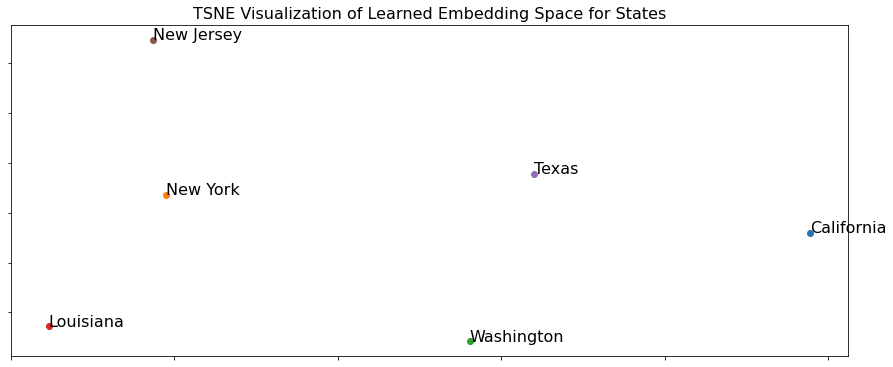

In [54]:
from sklearn import manifold
from matplotlib.ticker import NullFormatter
import typing

# get list of countries with most fatalities
def visualize_embedding(
    trained_net,
    states: typing.List[str] = None
):

    # visualize 2-D projection of learned State embedding space with TSNE
    embedding = trained_net.collect_params()[f'{trained_net.name}_featureembedder0_cat_0_embedding_weight'].data()
    proj = manifold.TSNE(init='pca', random_state = 0).fit_transform(embedding.asnumpy())

    # plot
    fig = plt.figure(figsize=(15, 6.1), facecolor="white",  edgecolor='k')
    ax = plt.gca()

    if states is None:
        states = enc.categories_[0]
    for state in states:
        idx = np.where(enc.categories_[0] == state)[0][0]
        plt.scatter(
            proj[idx, 0], 
            proj[idx, 1], 
            cmap=plt.cm.Spectral, 
        )
        ax.annotate(
            state, 
            (proj[idx, 0], proj[idx, 1]), 
            fontsize=16,
        )
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.title(f"TSNE Visualization of Learned Embedding Space for States", fontsize=16)
    plt.show()

visualize_embedding(net, states = ['California', 'New York', 'Washington', 'Louisiana', 'Texas', 'New Jersey'])